In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

 in WARNING: replacing module MatpowerCases
depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
 in anonymous at multi.jl:892
 in run_work_thunk at multi.jl:645
 [inlined code] from multi.jl:892
 in anonymous at task.jl:63
while loading /home/jkersulis/Documents/Dropbox/InstantonAnew/Jonas Edits/Time-Coupled Instanton/temporal-instanton/src/manipulations.jl, in expression starting on line 451
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in include_string at loading.jl:266
 in include_from_node1 at ./loading.jl:307
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
 in anonymous at multi.jl:892
 in run_work_thunk at multi.jl:645
 [inlined code] from multi.jl:892
 in

In [2]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(outputData.score)

in fillbuf at /home/jkersulis/.julia/v0.4/Zlib/src/Zlib.jl:264
in fillbuf at /home/jkersulis/.julia/v0.4/Zlib/src/Zlib.jl:264


104-element Array{Float64,1}:
    0.263788
    0.327316
    1.28861 
    2.20415 
    2.32297 
    2.42316 
    4.67876 
    4.86524 
    4.89917 
    5.67827 
    5.93862 
    6.43917 
    6.46089 
    ⋮       
  178.086   
  303.003   
  370.614   
  370.614   
  391.307   
  428.944   
  923.98    
  979.199   
 1319.85    
 1390.03    
 1967.27    
 1967.27    

9.136292 seconds (2.95 M allocations: 141.846 MB, 0.44% gc time)


In [3]:
num_farms_vec = collect(2:2:72)
gen_count = Vector{Int64}()
mpc = loadcase("case96",describe=false)
push!(gen_count,length(unique(mpc["gen"][:,1])))

sec_elapsed_agg = Vector{Vector{Float64}}()
reps = 5
for rep in 1:reps
    score_output = Array(Vector{Float64},0)
    sec_elapsed = Vector{Float64}()
    bytes_alloc = Vector{Float64}()
    sec_in_gc = Vector{Float64}()
    wind_count = Vector{Int64}()

    for i in 1:length(num_farms_vec)
        case = "case96"
        num_farms = num_farms_vec[i]
        push!(wind_count,num_farms)
        penetration = 0.5 # penetration of 50 %
        d = mat2tmpinst(case,num_farms,penetration)

        # Thermal model parameters:
        d.Tamb = 35. # C
        d.T0 = 60. #46. # initial line steady-state temp

        d.time_values = 0:600:3600 # one hour in 10-minute steps
        d.int_length = 3600. # seconds = one hour

        Gp,Dp,Rp = (d.G0, d.D0, d.R0)
        d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
        d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
        d.R0 = [Rp;1.1*Rp;1.2*Rp;1.1*Rp;Rp;0.9*Rp]

        n = length(d.k)
        nr = length(d.Ridx)
        T = convert(Int64,length(d.G0)/n)

        timed_results = @timed solve_temporal_instanton(d);
        results = timed_results[1]
        o = process_instanton_results(results,n,nr,T,return_as_type=true);
        push!(score_output,o.score)
        push!(sec_elapsed,timed_results[2])
        push!(bytes_alloc,timed_results[3])
        push!(sec_in_gc,timed_results[4])
    end
    push!(sec_elapsed_agg,sec_elapsed)

#     lines_processed = []
#     for score_vec in score_output
#         push!(lines_processed, sum(score_vec.!=Inf))
#     end
end

In [4]:
using PyPlot
PyPlot.svg(true)

true

In [18]:
all(lines_processed.==119)

true

In [23]:
for i in 1:length(score_output)
    if maximum(score_output[i]) == Inf
        println(i)
    end
end

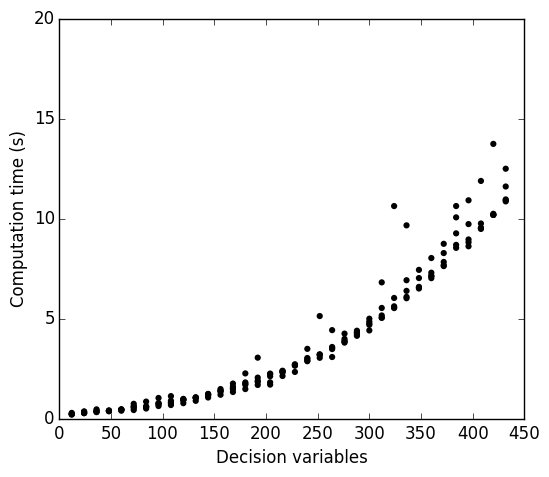

PyObject <matplotlib.text.Text object at 0x7f47f46f8710>

In [9]:
fig = figure(figsize=(6,5))
hold(true)

x = num_farms_vec*6

for i in 1:length(sec_elapsed_agg)
    y = sec_elapsed_agg[i]
    scatter(x,y,facecolor="black",alpha=1.,s=20,edgecolor="")
# yscale("log")
# xscale("log")
# ymin = 0.5
# ymax = 10^(4.7)
# ylim([ymin;ymax])
# xmin = 0.1
# xmax = 1e3
# xlim([xmin;xmax])
# axis("equal")
end
axis([0;450;0;20])
xlabel("Decision variables")
ylabel("Computation time (s)")
# xticks(size=10)
# yticks(size=10)

# savefig("../images/2015-09-17-rts-96-scaling.pdf",bbox_inches="tight")

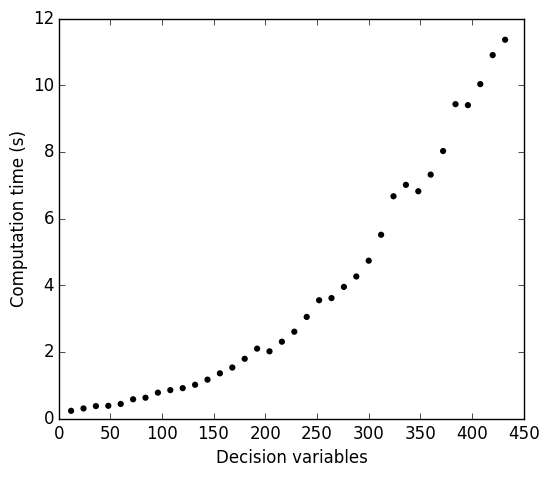

In [14]:
fig = figure(figsize=(6,5))
hold(true)

x = num_farms_vec*6
y = mean(sec_elapsed_agg)
scatter(x,y,facecolor="black",alpha=1.,s=20,edgecolor="")
axis([0;450;0;12])
xlabel("Decision variables")
ylabel("Computation time (s)")
# xticks(size=10)
# yticks(size=10)

savefig("../paper2/images/rts-96-scaling.pdf",bbox_inches="tight")